# use RandomForestRegressor to select feature

In [1]:
!pip install pydot

In [2]:
import os

import pydot
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import export_graphviz

In [3]:
RF_PATH = "../data/curated/rf_data/"
TREE_GRAPH_DOT_PATH = os.path.join(RF_PATH, "tree.dot")
TREE_GRAPH_PNG_PATH = os.path.join(RF_PATH, "tree.png")
RANDOM_FOREST_SEED = 66
N_ESTIMATORS = 10

In [4]:
# set rf folder
if not os.path.exists(RF_PATH):
    os.mkdir(RF_PATH)

# Get Data

In [5]:
sa2_df = pd.read_csv(r"../data/curated/sa2_info.csv")

In [6]:
sa2_df.columns

Index(['Unnamed: 0', 'SA2', 'school_count', 'ERP_population', 'median_income',
       'metrobus_count', 'metrotrain_count', 'metrotram_count', 'regbus_count',
       'regcoach_count', 'regtrain_count', 'skybus_count', 'recr_count',
       'comm_count', 'deal_count', 'median_rent', 'cbd_dis'],
      dtype='object')

In [7]:
# set x y
x_col = ['school_count', 'ERP_population', 'median_income',
         'metrobus_count', 'metrotrain_count', 'metrotram_count',
         'regbus_count', 'regcoach_count', 'regtrain_count', 'skybus_count', 
         'recr_count', 'comm_count', 'deal_count']
y = sa2_df['median_rent']

# Random Forest Model

In [8]:
random_forest_model = RandomForestRegressor(n_estimators=N_ESTIMATORS,
                                            random_state=RANDOM_FOREST_SEED)
random_forest_model.fit(sa2_df[x_col], y)

RandomForestRegressor(n_estimators=10, random_state=66)

In [9]:
# Draw decision tree visualizing plot
random_forest_tree = random_forest_model. estimators_[5]
export_graphviz(random_forest_tree, out_file=TREE_GRAPH_DOT_PATH,
                feature_names=x_col, rounded=True, precision=1)
(random_forest_graph,) = pydot.graph_from_dot_file(TREE_GRAPH_DOT_PATH)
random_forest_graph.write_png(TREE_GRAPH_PNG_PATH)

**Random Forest Tree**

![tree.png](../data/curated/rf_data/tree.png)

# Calculate the importance of variables

Text(0.5, 1.0, 'Variable Importances')

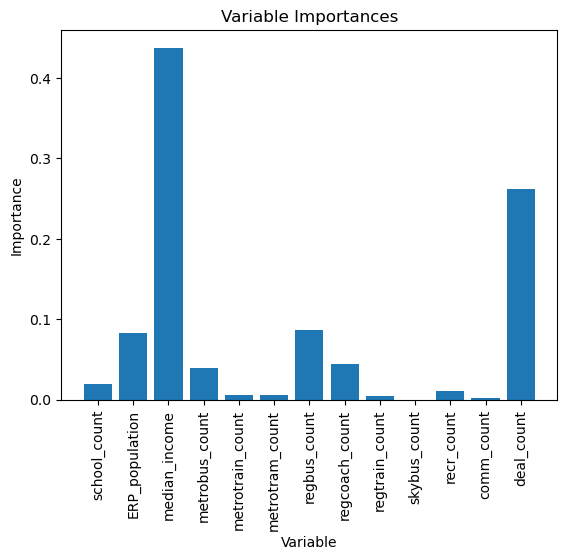

In [10]:
random_forest_importance = list(random_forest_model.feature_importances_)
random_forest_feature_importance = [(feature, round(importance, 8))
                                    for feature, importance in
                                    zip(x_col, random_forest_importance)]

random_forest_feature_importance = sorted(random_forest_feature_importance,
                                          key=lambda x: x[1], reverse=True)
plt.figure(3)
plt.clf()
importance_plot_x_values = list(range(len(random_forest_importance)))
plt.bar(importance_plot_x_values, random_forest_importance, 
        orientation='vertical')
plt.xticks(importance_plot_x_values, x_col, rotation='vertical')
plt.xlabel('Variable')
plt.ylabel('Importance')
plt.title('Variable Importances')

In [11]:
importance_dict = dict(zip(x_col, random_forest_importance))
sorted_data = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)

In [12]:
for fea, var in sorted_data:
    print(f"{fea:<25}{var:.5f}")

median_income            0.43774
deal_count               0.26215
regbus_count             0.08612
ERP_population           0.08254
regcoach_count           0.04398
metrobus_count           0.03972
school_count             0.01946
recr_count               0.01025
metrotram_count          0.00543
metrotrain_count         0.00541
regtrain_count           0.00516
comm_count               0.00205
skybus_count             0.00000


**In summary, the top 3 importance feature is `median_income, deal_count,ERP_population`**

## get the most liveable and affordable suburbs

In [13]:
sa2_df['best_suburb_score'] = 0.2*sa2_df['median_income'] +\
                              0.2*sa2_df['deal_count'] +\
                              0.2*sa2_df['ERP_population'] +\
                              0.1*sa2_df['metrotrain_count'] +\
                              0.1*sa2_df['school_count'] +\
                              0.1*sa2_df['recr_count'] +\
                              0.1*sa2_df['regbus_count']

In [15]:
best_suburb_df = pd.DataFrame(sa2_df, columns=['SA2', 'best_suburb_score'])

In [16]:
match_df = pd.read_csv(f"../data/raw/ABS/SA2_TO_Name.csv")
match_df = match_df[["code", "name"]]

best_suburb_df = best_suburb_df.reset_index()
best_suburb_df = pd.merge(match_df, best_suburb_df, left_on="code", right_on="SA2", how="right")
# best_suburb_df = best_suburb_df.set_index("name").drop(["index"], axis=1)

sort_predict = best_suburb_df.sort_values(by=['best_suburb_score'], ascending=False, inplace=False)

top_10 = list(sort_predict.index)[:10]

## the top 10 liveable and affordable suburbs is：


In [19]:
sort_predict[:10]

,code,name,index,SA2,best_suburb_score
235,206061136,Prahran - Windsor,235,206061136,7013.9
63,213021344,Newport,63,213021344,6454.4
109,208041195,Malvern East,109,208041195,6411.4
33,208021177,Caulfield - North,33,208021177,6300.9
247,212051326,Oakleigh - Huntingdale,247,212051326,6207.1
76,206031113,Ascot Vale,76,206031113,6167.5
261,207021157,Doncaster,261,207021157,6104.9
135,208011169,Brighton (Vic.),135,208011169,5988.2
189,206051130,Port Melbourne,189,206051130,5963.2
285,206071143,Fitzroy North,285,206071143,5946.3
